### 种族分布模型

#### 背景
气候通常是影响种族分组最重要的因素之一。 每个圣湖适应特定气候条件，

这就是“气候生态位”（climate niche），

“基本生态位”（fundamental niche）则是假设物种独立于其他物种存活的所有条件。

“现实生态位”（realized niche）是考虑到物种交互过程，可以存活的条件


由于温室气体排放，气候变得异常，生活喜欢居住的地理位置逐渐变化。

这些变化潜在地 影响当地环境和宏观生态，因为一些当地生物会受到威胁。

本章探讨 太平岩西北地区树种和气候的关系，以及气候变迁中这些物种分布变化。

本章设计三个新函数库，spatstas函数库，处理点数据模式；

dismo 函数库用来建模 物种分布模型

ROCR韩户口 用来生成用特性曲线和其他统计，以评估预测的准确性

In [1]:
setwd("C:/Users/thinkpad/Desktop/Data_analysis_courses/RandSpecialAnalysis/Chapter12")

In [10]:
library(tidyverse)
library(sf)
library(terra)
library(colorspace)
library(ggspatial)
library(dismo)
library(spatstat)
library(ROCR)
source("rasterdf.R")

Warning message:
"package 'ROCR' was built under R version 4.3.3"


### 树种数据

此研究使用华盛顿州的喀斯喀特山脉，

此地区包括 3 个生态区：喀斯喀特河、东喀斯喀特河和北喀斯喀特河

三地区的矢量数据（polygons）

数据来自美国林务局和其他土地管理机构监测的森林盘查地块



In [11]:
wacascades <- st_read("wacascades.shp", quiet = TRUE)
abla <- read_csv("abla.csv")
psme <- read_csv("psme.csv")

Rows: 4356 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): abla, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4685 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): psme, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


把 abla 和 psme 数据转化成 df

In [12]:
abla_pts <- st_as_sf(abla, 
                     coords = c("X", "Y")) 
st_crs(abla_pts) <- 4326
psme_pts <- st_as_sf(psme, 
                     coords = c("X", "Y")) 
st_crs(psme_pts) <- 4326

存在-缺失点图显示，亚高山冷杉仅限于靠近峰顶的拔地区。

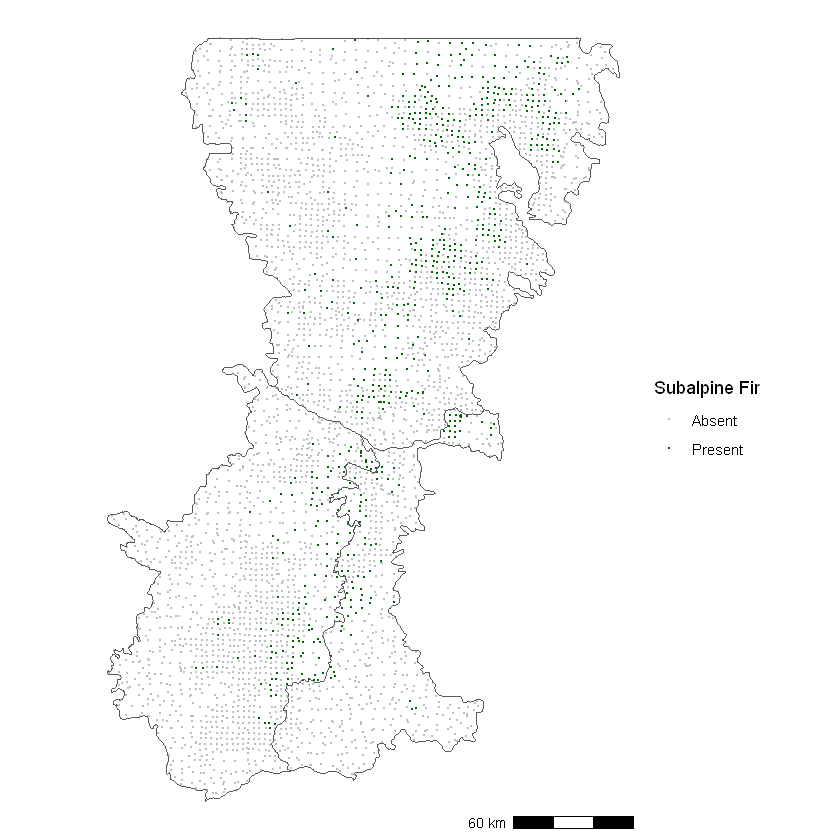

In [13]:
ggplot() +
  geom_sf(data = abla_pts,
          aes(color = as.character(abla)), 
          size = 0.25) +
  geom_sf(data = wacascades, 
          fill = NA) +
  scale_color_manual(name = "Subalpine Fir",
                     values = c("gray", "darkgreen"),
                     labels = c("Absent", "Present")) +
  annotation_scale(location = 'br') +
  theme_void()

火灾在低海拔和东岸分布更广

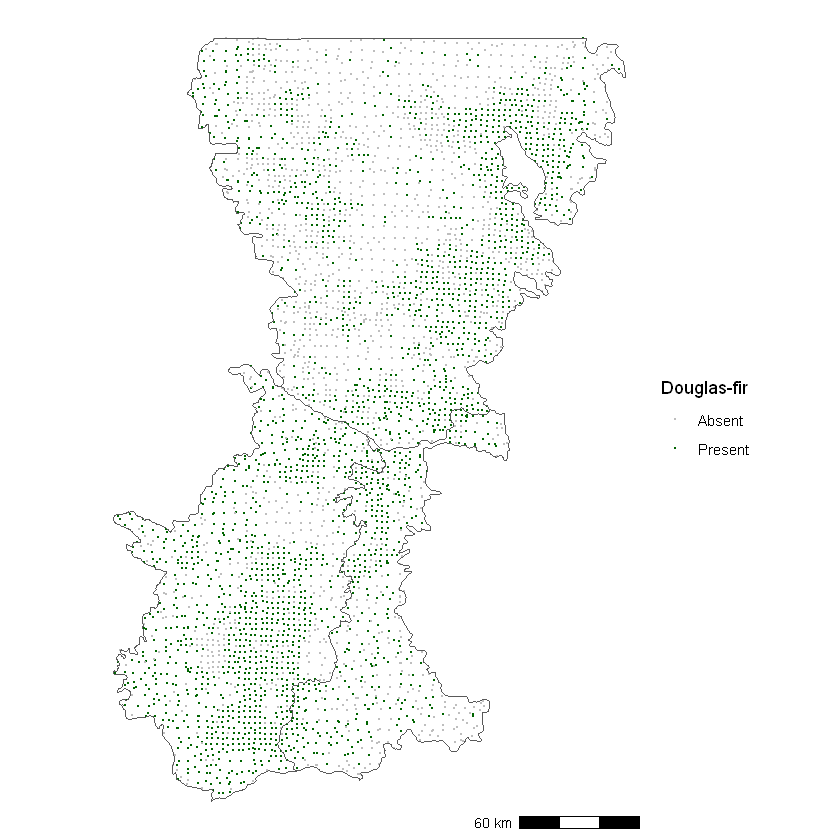

In [14]:
ggplot() +
  geom_sf(data = psme_pts,
          aes(color = as.character(psme)), 
          size = 0.25) +
  geom_sf(data = wacascades, 
          fill = NA) +
  scale_color_manual(name = "Douglas-fir",
                     values = c("gray", "darkgreen"),
                     labels = c("Absent", "Present")) +
  annotation_scale(location = 'br') +
  theme_void()

##### 用点图并不能很好的呈现分布，我们使用 核加权局部均值（kernel-weighted local means）

从点转化为 raster，每个栅格单元被分配一个局部的平均值，近距离的赋权重更大

1、首先把所有数据由地理坐标系（geographic coordinate system）改成投影坐标系（projected coordinate system），reprojected into UTM zone 10 north.

In [15]:
boundary_utm <- st_transform(wacascades, 32610)
abla_utm <- st_transform(abla_pts, 32610)
psme_utm <- st_transform(psme_pts, 32610)

2、计算 kernel-weighted means 需要用spatstat 库，但该库函数不认 sf

因此首先需要转化成 spatstat 的 ppp 格式

as.owin() 生成 window 应用到 ppp 上


In [16]:
abla_ppp <- as.ppp(abla_utm)
class(abla_ppp)

[1] "ppp"

In [17]:
Window(abla_ppp) <- as.owin(boundary_utm)
abla_ppp

Marked planar point pattern: 4356 points
marks are numeric, of storage type  'double'
window: polygonal boundary
enclosing rectangle: [511678.3, 760623.9] x [5046278, 5432695] units

3、使用Smooth.ppp()完成局部核加权， 

sigma 代表核的辐射范围，圆形窗口的覆盖半径

eps指定输出 cell 的大小，

最后输出是“im”格式

In [18]:
abla_im <- Smooth.ppp(abla_ppp, 
                      sigma=10000, 
                      eps=c(1000, 1000))
class(abla_im)

[1] "im"

In [19]:
abla_grid <- rast(abla_im)
crs(abla_grid) <-"epsg:32610"

Warning message:
"Removed 43327 rows containing missing values or values outside the scale range (`geom_raster()`)."


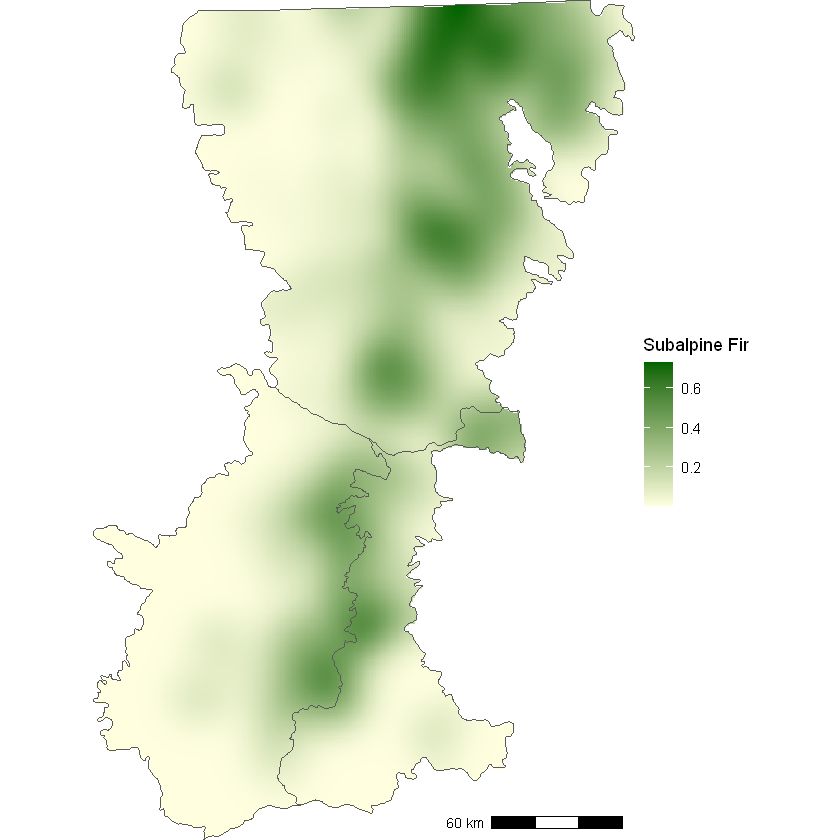

In [20]:
abla_df <- rasterdf(abla_grid)
ggplot(data = abla_df) +
  geom_raster(aes(x = x, 
                  y = y, 
                  fill = value)) +
  scale_fill_gradient(name = "Subalpine Fir", 
                      low = "lightyellow", 
                      high = "darkgreen",
                      na.value = NA) +
  geom_sf(data = boundary_utm,
          fill = NA) +
  annotation_scale(location = 'br') +
  coord_sf(expand = F) +
  theme_void()

同样方法应用于 Douglas-fir

Warning message:
"Removed 43327 rows containing missing values or values outside the scale range (`geom_raster()`)."


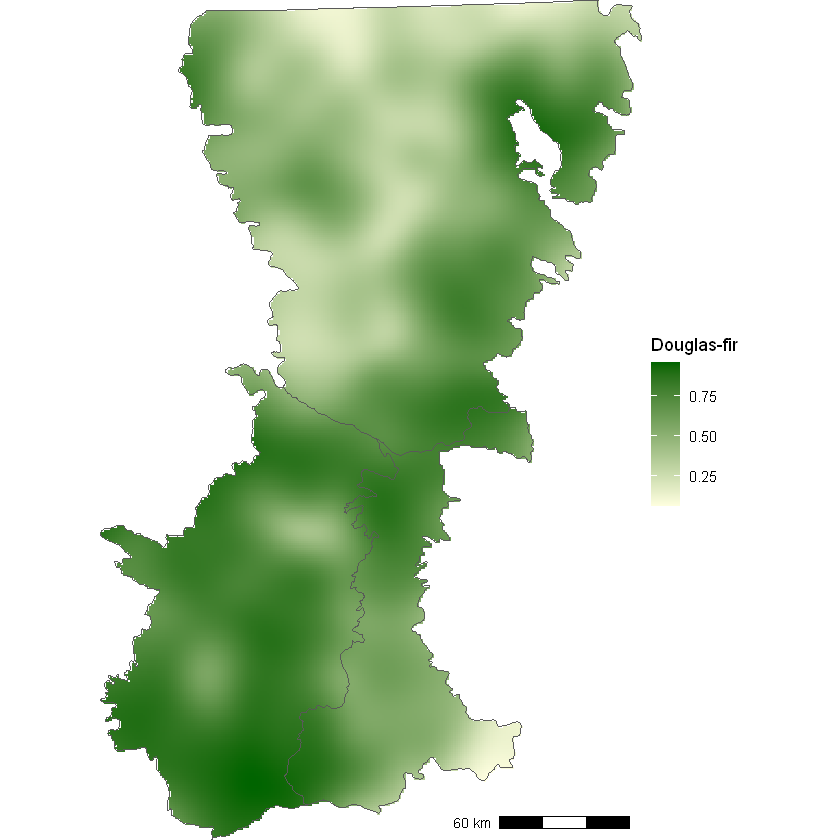

In [21]:
psme_ppp <- as.ppp(psme_utm)
Window(psme_ppp) <- as.owin(boundary_utm)
psme_im <- Smooth.ppp(psme_ppp, 
                      sigma=10000, 
                      eps=c(1000, 1000))
psme_grid <- rast(psme_im)
crs(psme_grid) <-"epsg:32610"
psme_df <- rasterdf(psme_grid)
ggplot(data = psme_df) +
  geom_raster(aes(x = x, 
                  y = y, 
                  fill = value)) +
  scale_fill_gradient(name = "Douglas-fir", 
                      low = "lightyellow", 
                      high = "darkgreen",
                      na.value = NA) +
  geom_sf(data = boundary_utm,
          fill = NA) +
  annotation_scale(location = 'br') +
  coord_sf(expand = F) +
  theme_void()

# 
### 12.2  世界气候历史数据

WorldClim数据集将用于分析树种与气候之间的关系。

In [22]:
wcbio <- rast("wc2.1_30s_bio_washington.tif")
nlyr(wcbio)

names(wcbio)

[1] 19

[1] "wc2.1_30s_bio_washington_1"  "wc2.1_30s_bio_washington_2" 
 [3] "wc2.1_30s_bio_washington_3"  "wc2.1_30s_bio_washington_4" 
 [5] "wc2.1_30s_bio_washington_5"  "wc2.1_30s_bio_washington_6" 
 [7] "wc2.1_30s_bio_washington_7"  "wc2.1_30s_bio_washington_8" 
 [9] "wc2.1_30s_bio_washington_9"  "wc2.1_30s_bio_washington_10"
[11] "wc2.1_30s_bio_washington_11" "wc2.1_30s_bio_washington_12"
[13] "wc2.1_30s_bio_washington_13" "wc2.1_30s_bio_washington_14"
[15] "wc2.1_30s_bio_washington_15" "wc2.1_30s_bio_washington_16"
[17] "wc2.1_30s_bio_washington_17" "wc2.1_30s_bio_washington_18"
[19] "wc2.1_30s_bio_washington_19"

 层名重命名

In [23]:
wcbnames <- paste0("bio", c(1, 10:19, 2:9))
names(wcbio) <- wcbnames
wcbnames

[1] "bio1"  "bio10" "bio11" "bio12" "bio13" "bio14" "bio15" "bio16" "bio17"
[10] "bio18" "bio19" "bio2"  "bio3"  "bio4"  "bio5"  "bio6"  "bio7"  "bio8" 
[19] "bio9"

我们取华盛顿瀑布的边界，重投影，确保 crs 与 Worldclim 一致

In [24]:
boundary_wgs84 <- st_transform(wacascades, st_crs(wcbio))
wcbio_crop <- crop(wcbio, vect(boundary_wgs84))
wcbio_msk <- mask(wcbio_crop, vect(boundary_wgs84))

山脉边缘和河谷的温度最高。沿着喀斯喀特峰和大型火山的峰顶温度最低

Warning message:
"Removed 75566 rows containing missing values or values outside the scale range (`geom_raster()`)."


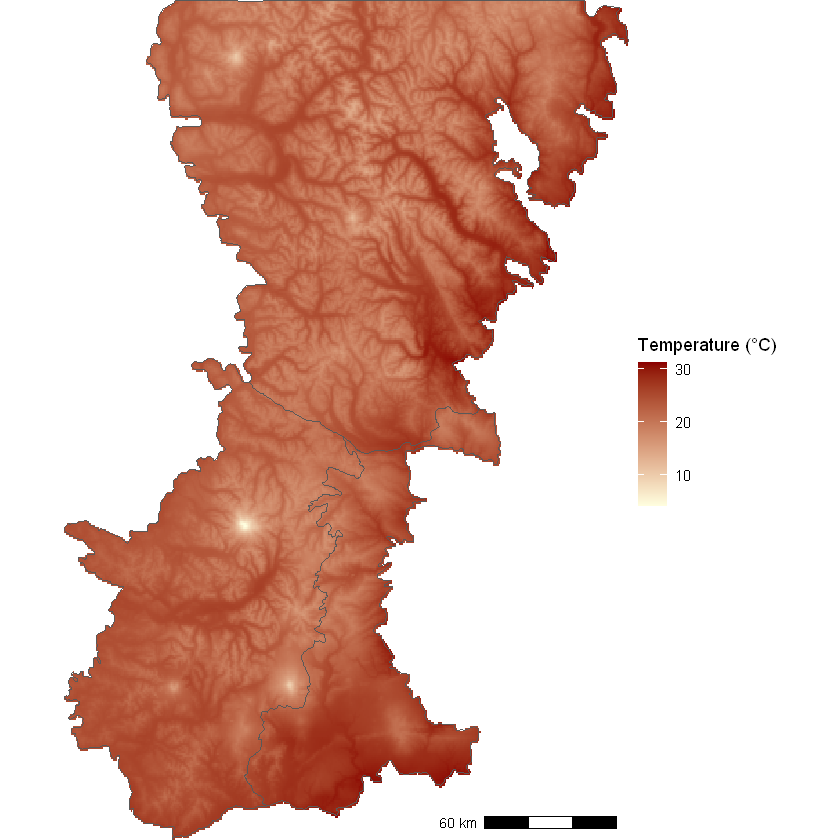

In [25]:
mtwm_df <- rasterdf(wcbio_msk[["bio5"]])
ggplot(data = mtwm_df) +
  geom_raster(aes(x = x, 
                  y = y, 
                  fill = value)) +
  scale_fill_gradient(name = "Temperature (\u00B0C)", 
                      low = "lightyellow", 
                      high = "darkred",
                      na.value = NA) +
  geom_sf(data = boundary_wgs84,
          fill = NA) +
  annotation_scale(location = 'br') +
  coord_sf(expand = F) +
  theme_void()

最高降水量出现在喀斯喀特峰以西，最低值出现在东坡的雨影处

Warning message:
"Removed 75566 rows containing missing values or values outside the scale range (`geom_raster()`)."


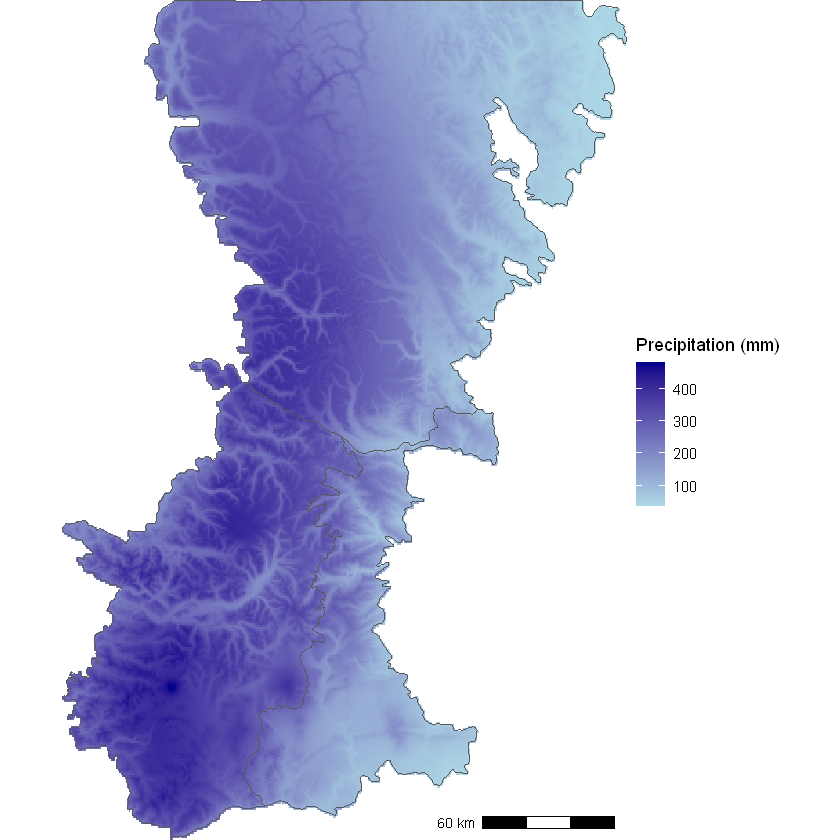

In [26]:
mtwm_df <- rasterdf(wcbio_msk[["bio13"]])
ggplot(data = mtwm_df) +
  geom_raster(aes(x = x, 
                  y = y, 
                  fill = value)) +
  scale_fill_gradient(name = "Precipitation (mm)", 
                      low = "lightblue", 
                      high = "darkblue",
                      na.value = NA) +
  geom_sf(data = boundary_wgs84,
          fill = NA) +
  annotation_scale(location = 'br') +
  coord_sf(expand = F) +
  theme_void()

### 12.3 Modeling the Climate Niche

1.亚高山冷杉

为了准备建模的数据，使用extract()函数从wcbio_mask获取亚高山冷杉数据集中气候变量。

In [29]:
abla_bio <- extract(wcbio_msk, vect(abla_pts)) %>%
  bind_cols(abla_pts) %>%
  as.data.frame()


In [30]:
names(abla_bio)

[1] "ID"       "bio1"     "bio10"    "bio11"    "bio12"    "bio13"   
 [7] "bio14"    "bio15"    "bio16"    "bio17"    "bio18"    "bio19"   
[13] "bio2"     "bio3"     "bio4"     "bio5"     "bio6"     "bio7"    
[19] "bio8"     "bio9"     "abla"     "geometry"

为检验模型预测准确性，采用交叉验证，取70%作为训练集

In [33]:
set.seed(22003)
abla_train <- abla_bio %>%
  sample_frac(size = 0.7)
abla_val <- abla_bio %>%
  anti_join(abla_train, by = "ID")

#### 增长回归树（Boosted Regression Trees，BRT）探讨过去和现在亚高山冷杉和19个生物气候变量的关系

BRT 是一种机器学习方法，它将回归树与增强算法结合起来，
通过一系列递归的二元分割将物种出现与一组气候变量相关联，
增强算法是一种集成方法，将许多简单模型结合起来以提高预测准确性。

Elith, J., Leathwick, J. R., & Hastie, T. (2008). A working guide to boosted regression trees. The Journal of animal ecology, 77(4), 802–813. https://doi.org/10.1111/j.1365-2656.2008.01390.x

使用 dismo 函数库，的 gbm.step() 建模


提供了一个包含训练数据的数据框架，同时提供了用作预测变量（gbm.x）和响应变量（gbm.y）的列的索引。

family = "bernoulli"表明模型将把响变量视为二分变量。

tree.complexity、learning.rate 和 bag.fraction 参数控制着用于拟合模型的梯度提升算法的各个方面。
请参考Elith、Leathwick 和 Hastie (2008)

In [35]:
abla_mod <- gbm.step(data = abla_train, 
                     gbm.x = 2:20, 
                     gbm.y = 21,
                     family = "bernoulli", 
                     tree.complexity = 3,
                     learning.rate = 0.01, 
                     bag.fraction = 0.5,
                     plot.main = FALSE, 
                     verbose = FALSE, 
                     silent = TRUE)

Loading required namespace: gbm



在运行模型后，可以使用 summary 函数提取有关预测变量的相对重要性的信息。
相对重要性基于变量被选择用于分割回归树的次数，以及对 BRT 模型的结果改进进行加权。
然后，重要性值被重新缩放，使它们总和为100。

对于亚高山冷杉，年均温度（bio1）在模型中的影响比其他任何生物气候变量都要大，
其次是最暖季的平均温度（bio10）、最干季的平均温度（bio9）和最暖季的降水量（bio18）。

In [36]:
abla_imp <- summary(abla_mod, plotit = FALSE)
abla_imp

,var,rel.inf
,<chr>,<dbl>
bio1,bio1,36.0562317
bio10,bio10,8.0557059
bio9,bio9,6.2651729
bio18,bio18,6.0591309
bio3,bio3,5.9187074
bio17,bio17,5.1232150
bio15,bio15,4.4587608
bio14,bio14,4.4537895
bio8,bio8,4.2289912


可视化前四个变量

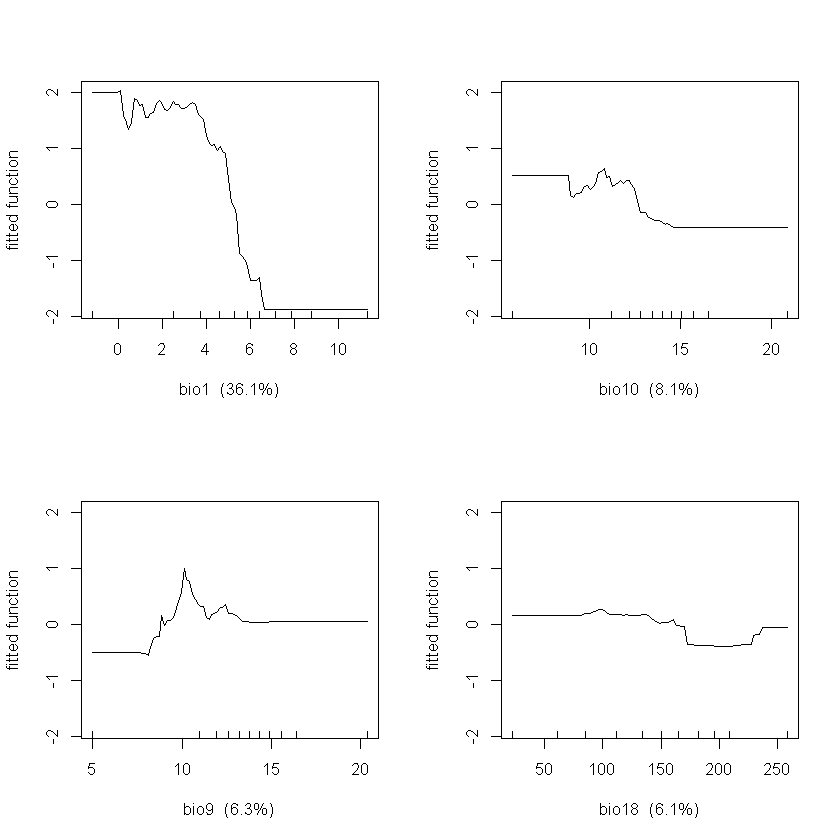

In [37]:
gbm.plot(abla_mod, 
         n.plots = 4, 
         write.title = FALSE,
         plot.layout = c(2, 2))

基于WorldClim生物气候变量的预测地图显示出与地形相关的更多局部变异性。

type = "response"，以将预测值转换为0-1尺度，
na.rm = TRUE 去掉在研究区域外没有数据的地方的预测值。

In [39]:
abla_cur <- predict(object = wcbio_msk, 
                    model = abla_mod, 
                    type = "response", 
                    na.rm = TRUE)

Using 2450 trees...


Using 2450 trees...


Using 2450 trees...




Warning message:
"Removed 75566 rows containing missing values or values outside the scale range (`geom_raster()`)."


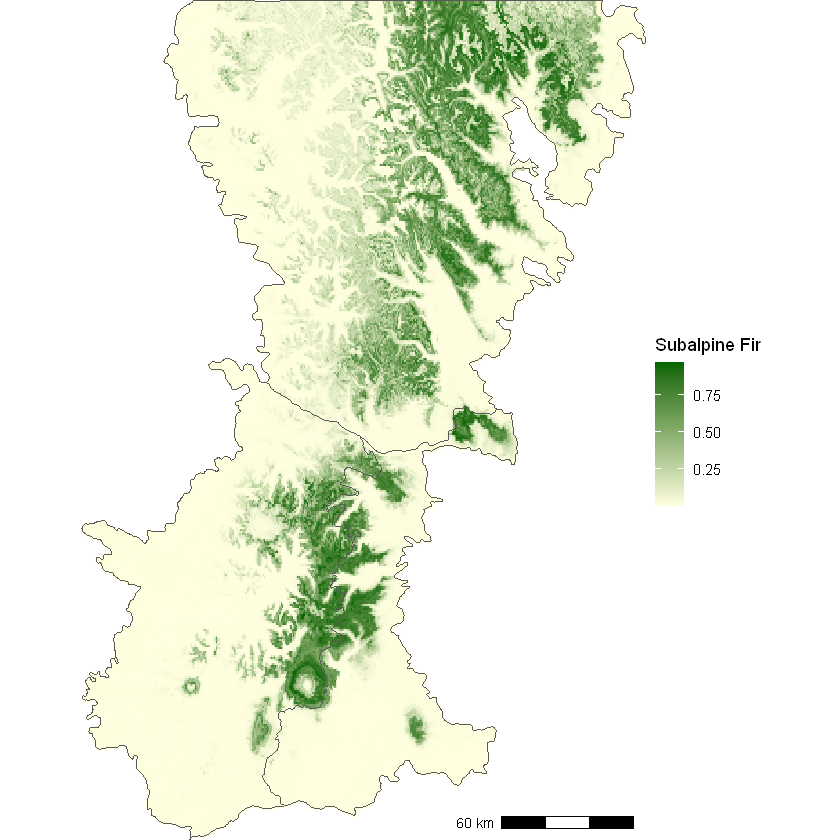

In [40]:
abla_cur_df <- rasterdf(abla_cur)
ggplot(data = abla_cur_df) +
  geom_raster(aes(x = x, 
                  y = y, 
                  fill = value)) +
  scale_fill_gradient(name = "Subalpine Fir", 
                      low = "lightyellow", 
                      high = "darkgreen",
                      na.value = NA) +
  geom_sf(data = boundary_wgs84,
          fill = NA) +
  annotation_scale(location = 'br') +
  coord_sf(expand = F) +
  theme_void()

# 12.3.2 道格拉斯冷杉
准备数据

In [41]:
set.seed(22004)
psme_bio <- extract(wcbio_msk, vect(psme_pts)) %>%
  bind_cols(psme_pts) %>%
  as.data.frame()
psme_train <- psme_bio %>%
  sample_frac(size = 0.7)
psme_val <- psme_bio %>%
  anti_join(abla_train, by = "ID")
psme_mod <- gbm.step(data=psme_train, 
                     gbm.x = 2:20, 
                     gbm.y = 21,
                     family = "bernoulli", 
                     tree.complexity = 3,
                     learning.rate = 0.01, 
                     bag.fraction = 0.5,
                     plot.main = FALSE, 
                     verbose = FALSE, 
                     silent = TRUE)

与亚高山冷杉相比，道格拉斯冷杉的变量重要性排名不同。最重要的两个变量，

最暖月的最高温度（bio5）和最暖季的平均温度（bio10），

其相对重要性比其他变量高得多。

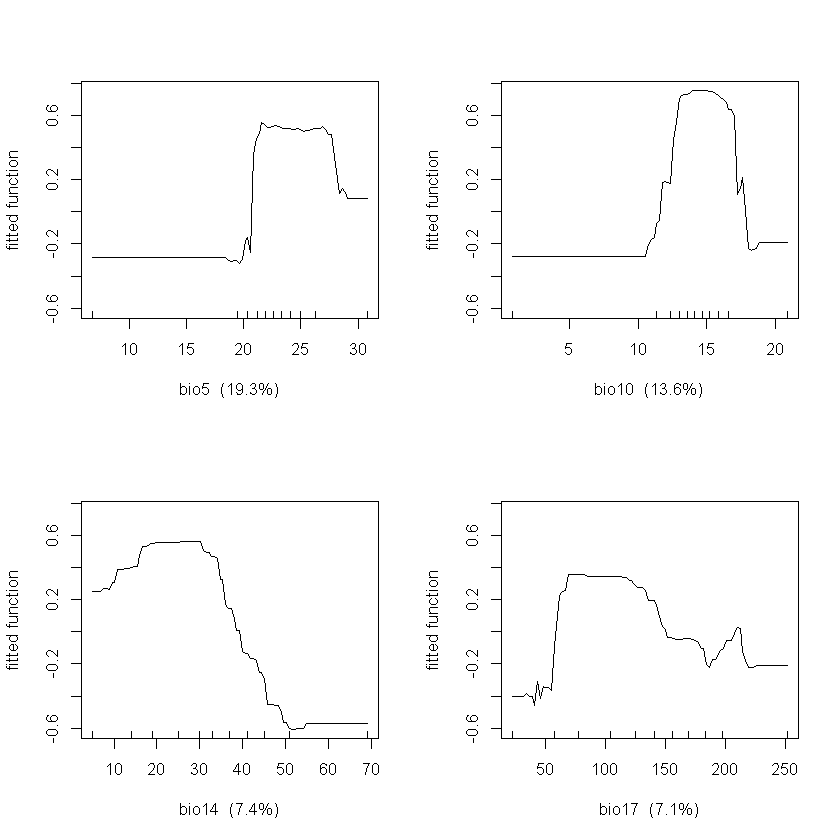

In [42]:
gbm.plot(psme_mod, 
         n.plots = 4, 
         write.title = FALSE,
         plot.layout = c(2, 2))

Using 2200 trees...


Using 2200 trees...


Using 2200 trees...


Warning message:
"Removed 75566 rows containing missing values or values outside the scale range (`geom_raster()`)."


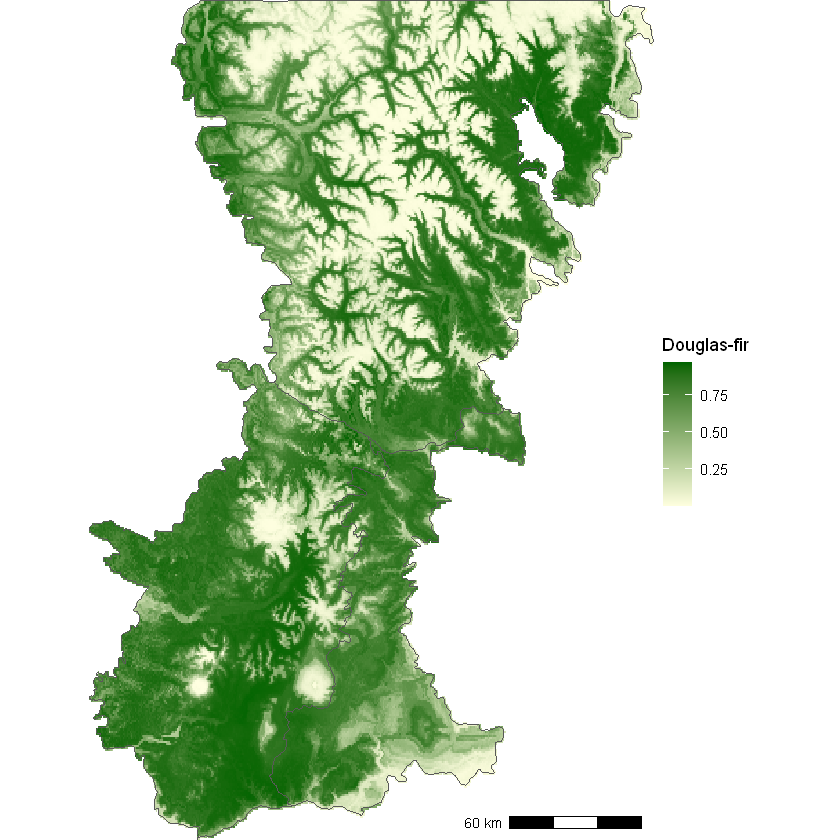

In [43]:
psme_cur <- predict(object = wcbio_msk, 
                    model = psme_mod, 
                    type = "response", 
                    na.rm = TRUE)
psme_cur_df <- rasterdf(psme_cur)
ggplot(data = psme_cur_df) +
  geom_raster(aes(x = x, 
                  y = y, 
                  fill = value)) +
  scale_fill_gradient(name = "Douglas-fir", 
                      low = "lightyellow", 
                      high = "darkgreen",
                      na.value = NA) +
  geom_sf(data = boundary_wgs84,
          fill = NA) +
  annotation_scale(location = 'br') +
  coord_sf(expand = F) +
  theme_void()

# 12.4 Accuracy Assessment

为了了解物种分布模型预测的准确性，使用 predict() 

第一个参数是 gbm 模型，

新数据参数用于指定 abla_val 数据框，

使用 ROCR 软件包的 prediction() 函数计算准确性

In [44]:
abla_pred <- predict(abla_mod, 
                     newdata = abla_val,
                     type = "response")
abla_predobs <- prediction(abla_pred, abla_val$abla)

Using 2450 trees...




尽管观测值是二进制的，但模型的输出是在零到一之间的连续概率。

ROC 曲线描述了在所有可能的截距值上真正阳性率和假正率的变化。

In [45]:
abla_roc = performance(abla_predobs, 
                       measure = "tpr", 
                       x.measure = "fpr")
class(abla_roc)


[1] "performance"
attr(,"package")
[1] "ROCR"

可视化

In [46]:
abla_fpr <- slot(abla_roc, "x.values")[[1]]
abla_tpr <- slot(abla_roc, "y.values")[[1]]
abla_aucplot <- data.frame(abla_fpr, abla_tpr)

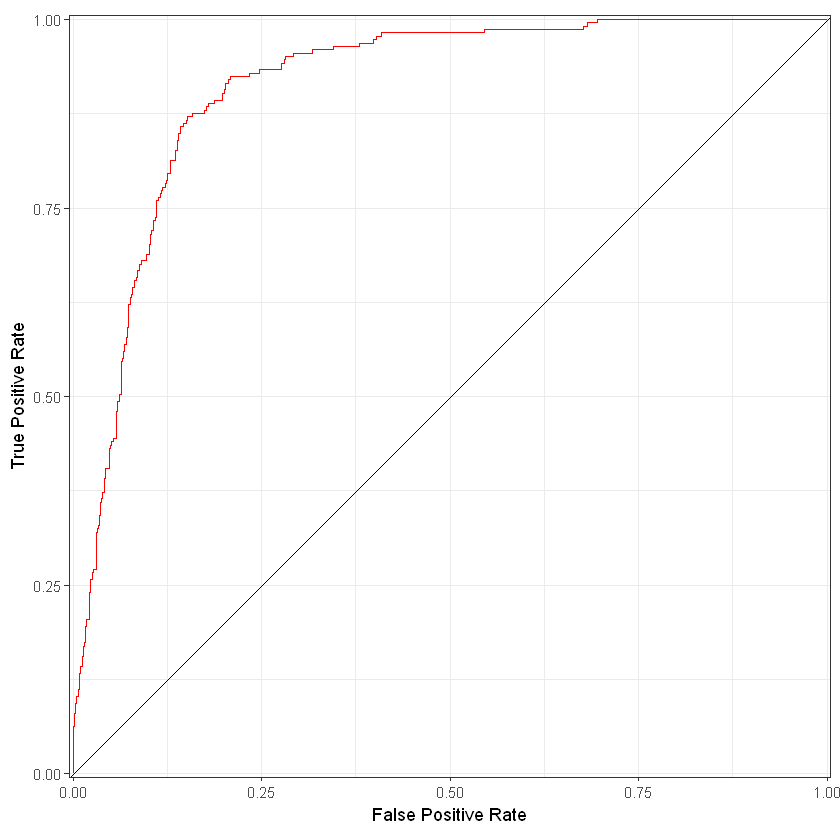

In [47]:
ggplot(data = abla_aucplot) +
  geom_line(aes(x = abla_fpr,
                y = abla_tpr),
            col = "red") +
  labs(x = "False Positive Rate", 
       y = "True Positive Rate") +
  geom_abline(slope = 1, intercept = 0) +
  scale_x_continuous(expand = c(0.005, 0)) +
  scale_y_continuous(expand = c(0.005, 0)) +
  coord_fixed() +
  theme_bw()

可视化这些关系的另一种方式是将总体准确性、真正阳性率和真负率作为预测截断值的函数来绘制。使用 performance() 函数创建包含这三个统计量的性能对象。
然后提取这些值并将它们合并成长格式的数据框。

In [48]:
abla_all = performance(abla_predobs, 
                       measure = "acc")
abla_pos = performance(abla_predobs, 
                       measure = "tpr")
abla_neg = performance(abla_predobs, 
                       measure = "tnr")
cutoff <- slot(abla_all, "x.values")[[1]]
totacc <- slot(abla_all, "y.values")[[1]]
posacc <- slot(abla_pos, "y.values")[[1]]
negacc <- slot(abla_neg, "y.values")[[1]]
abla_accplot <- data.frame(cutoff,
                           totacc,
                           posacc,
                           negacc) %>%
  pivot_longer(cols = one_of("totacc", 
                             "posacc", 
                             "negacc"),
               values_to = "accval",
               names_to = "accstat")

结果表明，基于预测，大约在0.25左右的截断值会有效地分类存在或不存在。
总体准确性接近最大值，并且真负率和真正率平衡且相对较高。

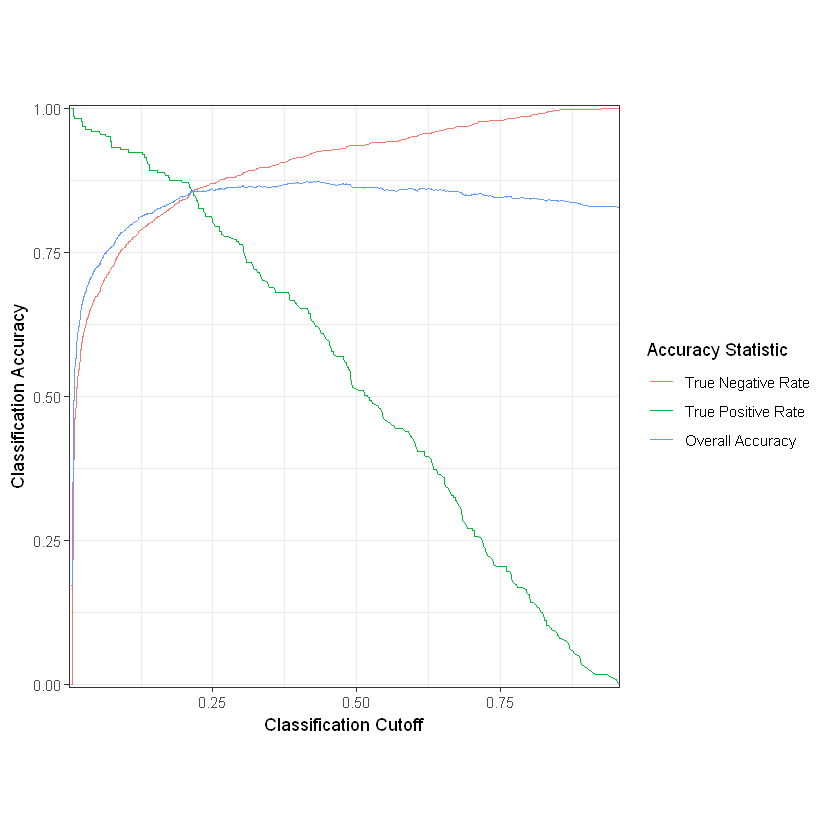

In [49]:
ggplot(data = abla_accplot) +
  geom_line(aes(x = cutoff, 
                y = accval,
                col = accstat)) +
    labs(x = "Classification Cutoff", 
         y = "Classification Accuracy",
         color = "Accuracy Statistic") +
  scale_color_discrete(labels = c("True Negative Rate",
                                 "True Positive Rate",
                                 "Overall Accuracy")) +
  scale_x_continuous(expand = c(0.005, 0)) +
  scale_y_continuous(expand = c(0.005, 0)) +
  coord_fixed() +
  theme_bw()

ROC 曲线下的面积，通常简称为 AUROC 或仅为 AUC，
经常用作对类似物种存在/不存在的二进制数据的概率模型的预测能力的指标。
该值范围从最小值0.5到最大值1.0。可以使用 performance() 函数计算 AUC 统计量。

In [50]:
abla_aucval <- performance(abla_predobs, measure = "auc")
slot(abla_aucval, "y.values")[[1]]

[1] 0.910495

# 12.5 Climate Change Projections

WorldClim 数据集还包括基于耦合模型比较计划（CMIP）第6版的全球环流模型（GCMs）输出的未来气候格网。
本示例使用来自马克斯·普朗克地球系统模型（MPI-ESM1.2）的2061-2080年的预测。
它基于RCP4.5全球强迫路径，该路径假定二氧化碳（CO2）排放将在2045年之前开始下降，并在2100年达到其2050年水平的大约一半。
这些变量是针对历史气候学计算的相同生物气候指数。数据被读入一个栅格对象，分配了图层名称，并被裁剪和掩蔽到华盛顿喀斯喀特山区的研究区域。

In [51]:
wcproj <- rast("wc2.1_30s_bioc_MPI-ESM1-2-HR_ssp245_2061-2080_wa.tif")
nlyr(wcproj)

wcbnames <- paste0("bio", 1:19)
names(wcproj) <- wcbnames
wcproj_crop <- crop(wcproj, vect(boundary_wgs84))
wcproj_msk <- mask(wcproj_crop, vect(boundary_wgs84))

[1] 19

使用 terra 的 predict() 函数生成亚高山冷杉在未来气候情景下的分布预测。
object 参数用于指定具有预测气候变量的栅格。
该栅格必须具有与用于训练模型的原始变量相同的图层名称。
输出 abla_proj 与当前条件下的预测 abla_cur 结合，创建一个多层栅格。

In [52]:
abla_proj <- predict(object = wcproj_msk, 
                     model = abla_mod, 
                     type = "response", 
                     na.rm = TRUE)
abla_chg <- c(abla_cur, abla_proj)
names(abla_chg) <- c("Current", "Future")

Using 2450 trees...


Using 2450 trees...


Using 2450 trees...




为了将预测显示为二进制的存在或不存在结果，使用截距值0.25对概率进行分类。

In [53]:
abla_clas <- ifel(abla_chg > 0.25, 1, 0)

比较这两幅地图显示，在未来更温暖的气候下，亚高山冷杉的预计分布范围要小得多，
该物种仅限于华盛顿喀斯喀特山脉的最高海拔区域

Warning message:
"Removed 151132 rows containing missing values or values outside the scale range (`geom_raster()`)."


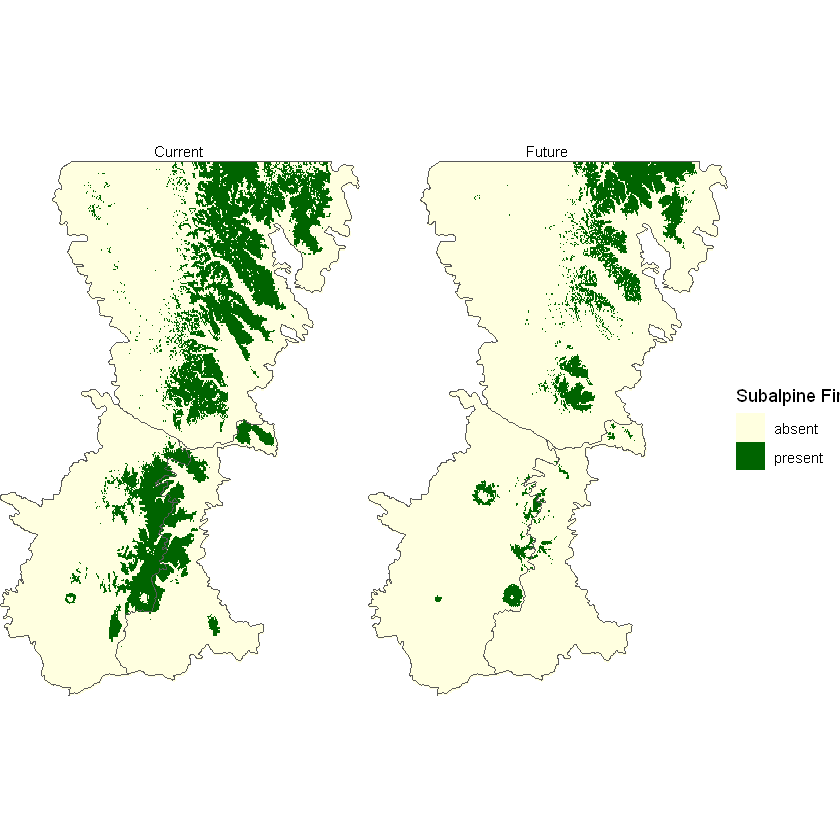

In [54]:
abla_clas_df <- rasterdf(abla_clas)
ggplot(data = abla_clas_df) +
  geom_raster(aes(x = x, 
                  y = y, 
                  fill = as.character(value))) +
  scale_fill_manual(name = "Subalpine Fir", 
                      values = c("lightyellow", 
                                 "darkgreen"),
                      labels = c("absent",
                                 "present"),
                      na.translate = FALSE) +
  facet_wrap(~ variable) +
  geom_sf(data = boundary_wgs84,
          fill = NA) +
  coord_sf(expand = F) +
  theme_void()

除了生成地图外，由 rasterdf() 函数生成的数据框也可以用于基于栅格数据集中的值创建其他类型的图表。在这个例子中，当前和未来年均温度的直方图显示，在未来气候情景下，温度分布将显著增加。

Warning message:
"Removed 151132 rows containing non-finite outside the scale range (`stat_bin()`)."


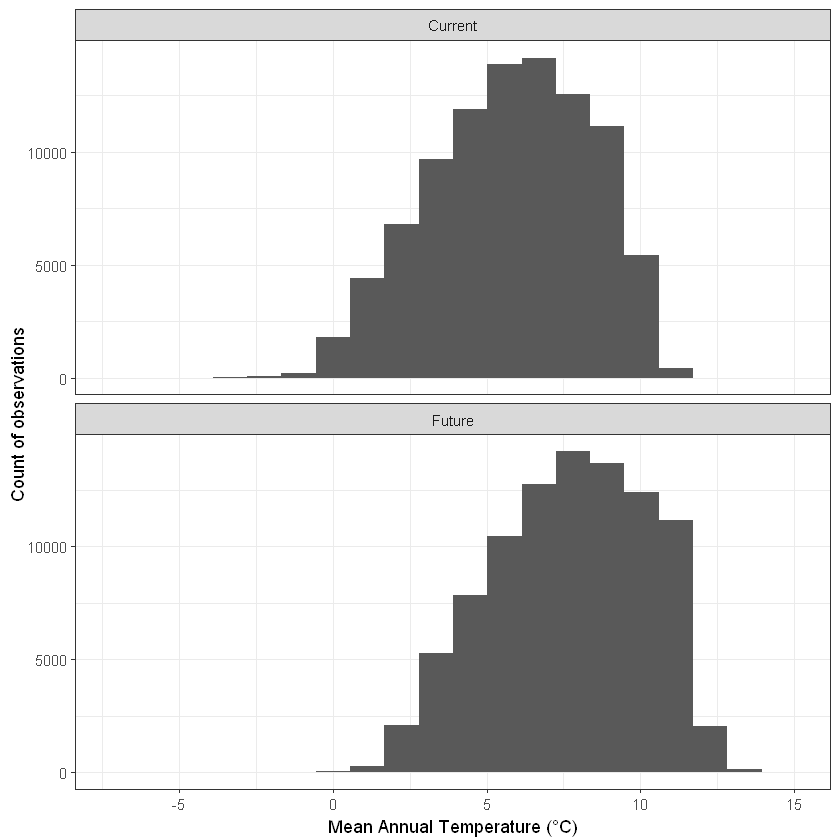

In [55]:
annmean <- c(wcbio_msk[["bio1"]], wcproj_msk[["bio1"]])
names(annmean) <- c("Current", "Future")
annmean_df <- rasterdf(annmean) 

ggplot(data = annmean_df) +
  geom_histogram(aes(x = value), bins = 20) +
  labs(x = "Mean Annual Temperature (\u00B0C)", 
       y = "Count of observations") +
  facet_wrap(~ variable, ncol = 1) +
  theme_bw()